In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from rdflib import Graph
import numpy as np
import scipy

from pykeen.triples import TriplesFactory
import pykeen
from pykeen.pipeline import pipeline

import matplotlib.pyplot as plt

In [2]:
def load_dataset(path, name):
    triple_data = open(path + name).read().strip()
    data = np.array([triple.split(',') for triple in triple_data.split('\n')])
    tf_data = TriplesFactory.from_labeled_triples(triples=data)
    return tf_data, triple_data


def create_model(tf_training, tf_testing, embedding, n_epoch, path):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,
        training_loop='sLCWA',
#         negative_sampler='bernoulli',
        negative_sampler_kwargs=dict(
        filtered=True,
        ),
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='gpu',
    )
    model = results.model
    results.save_to_directory(path + embedding)
    return model, results


def get_learned_embeddings(model):
    entity_representation_modules: List['pykeen.nn.RepresentationModule'] = model.entity_representations
    relation_representation_modules: List['pykeen.nn.RepresentationModule'] = model.relation_representations

    entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
    relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

    entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
    relation_embedding_tensor: torch.FloatTensor = relation_embeddings()
    return entity_embedding_tensor, relation_embedding_tensor


def create_dataframe_predicted_entities(entity_embedding_tensor, entity, training):
    df = pd.DataFrame(entity_embedding_tensor.cpu().detach().numpy())
    df['target'] = list(training.entity_to_id)
    new_df = df.loc[df.target.isin(list(entity))]
    return new_df.iloc[:, :-1], new_df, df


def cosine_sim(x, y):
    return abs(1 - scipy.spatial.distance.cosine(x, y))


def matrix_similarity(new_df, f_dist, th):
    array = new_df.set_index('target')
    entity = list(array.index.values)
    sim_matrix = pd.DataFrame(index=entity, columns=entity)
    sim_matrix = sim_matrix.fillna(0.0)
    list_sim = []

    for index, row in array.iterrows():
        for indexC, rowC in array.iterrows():
            sim = f_dist(row.values, rowC.values)
            sim = round(sim, 5)
            sim_matrix.at[index, indexC] = sim
            list_sim.append(sim)
    
    threshold = np.percentile(list_sim, th)
    print("percentil", threshold)
    #for col in sim_matrix.columns:
    #    sim_matrix.loc[sim_matrix[col] < threshold, [col]] = 0
    return sim_matrix, threshold


# === Save cosine similarity matrix with the structure SemEP need
def SemEP_structure(name, sim_matrix, sep):
    f = open(name, mode="w+")
    f.write(str(sim_matrix.shape[0]) + "\n")
    f.close()
    sim_matrix.to_csv(name, mode='a', sep=sep, index=False, header=False, float_format='%.5f')
    

def create_entitie(list_n, ENTITIES_FILE):
    entities = "\n".join(str(x) for x in list_n)
    n_ent = str(len(list_n))
    entity = open(ENTITIES_FILE, mode="w+")
    entity.write(n_ent + "\n" + entities)
    entity.close()

In [3]:
tf_data, triple_data = load_dataset('dataset/','country_ind.csv')

In [4]:
# triples = np.loadtxt('dataset/country_ind.csv', dtype=str, delimiter=",")
# tf = TriplesFactory.from_labeled_triples(triples)
training, testing = tf_data.split(random_state=1234)

In [5]:
testing

TriplesFactory(num_entities=222, num_relations=15, num_triples=466, inverse_triples=False)

In [6]:
training

TriplesFactory(num_entities=222, num_relations=15, num_triples=1863, inverse_triples=False)

In [8]:
model, results = create_model(training, testing, 'DistMult', 100, 'dataset/')

Training epochs on cuda:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


Evaluating on cuda:   0%|          | 0.00/466 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


In [9]:
results.metric_results.to_df()

,Side,Type,Metric,Value
0,head,realistic,hits_at_1,0.017167
1,head,realistic,hits_at_3,0.060086
2,head,realistic,hits_at_5,0.103004
3,head,realistic,hits_at_10,0.188841
4,head,realistic,arithmetic_mean_rank,58.778970
...,...,...,...,...
136,both,pessimistic,inverse_harmonic_mean_rank,0.332303
137,both,pessimistic,inverse_median_rank,0.250000
138,both,pessimistic,rank_std,45.169533
139,both,pessimistic,rank_var,2040.286691


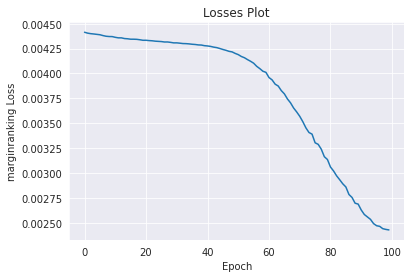

In [10]:
results.plot_losses()
plt.show()

In [11]:
entity_embedding_tensor, relation_embedding_tensor = get_learned_embeddings(model)
entity_embedding_tensor

tensor([[-0.1095, -0.1721,  0.0349,  ..., -0.3826, -0.1422, -0.0254],
        [-0.0636, -0.0810,  0.0306,  ..., -0.3701,  0.0591, -0.2288],
        [-0.0097,  0.2794, -0.0206,  ..., -0.3423, -0.1021, -0.0964],
        ...,
        [-0.1346, -0.2433,  0.0924,  ...,  0.2708,  0.0377,  0.2211],
        [-0.0524, -0.2580, -0.0626,  ...,  0.2577,  0.0906,  0.2055],
        [-0.1166,  0.2528,  0.0936,  ...,  0.2541,  0.1321,  0.2203]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [12]:
tf_dataset = pd.read_csv('dataset/country_ind.csv', delimiter=",")
entity = list(tf_dataset.country.unique())
df_predicted_entities, new_df, df_g1 = create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,-0.109535,-0.172136,0.034856,0.191456,0.132953,0.096211,-0.115386,-0.021502,-0.067043,0.054979,...,0.189690,-0.034705,0.051989,-0.014737,0.020784,-0.019264,-0.382574,-0.142197,-0.025415,Afghanistan
1,-0.063650,-0.081039,0.030566,-0.180667,-0.025150,-0.055397,0.031259,-0.134504,0.040779,0.069304,...,-0.200811,-0.054435,0.139659,-0.027064,0.009182,-0.020458,-0.370115,0.059093,-0.228810,Albania
2,-0.009725,0.279375,-0.020606,0.014898,-0.136788,-0.057076,0.006547,-0.238454,0.006839,0.059523,...,-0.211385,0.013589,-0.007440,-0.019627,0.099352,-0.059566,-0.342295,-0.102095,-0.096387,Algeria
3,0.057587,-0.266265,-0.124777,0.052762,0.089024,0.135572,0.200834,0.161387,0.023612,-0.081075,...,-0.048454,-0.101529,0.088384,-0.128759,0.195314,-0.020070,-0.288077,0.032542,0.073493,American Samoa
4,-0.085896,0.057083,-0.028968,0.109901,-0.095613,-0.029473,-0.164599,0.065691,-0.059553,0.092506,...,-0.311784,0.023285,0.031767,0.082508,0.027967,0.030352,-0.267756,0.017007,0.033446,Andorra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0.138664,-0.063290,0.106482,0.087703,0.129445,-0.173751,0.114291,0.039555,-0.080338,0.107250,...,-0.205635,0.035375,0.033412,0.064217,0.063872,-0.072725,-0.231947,0.051043,-0.026072,Virgin Islands (U.S.)
211,0.100673,-0.039112,0.085170,-0.046905,0.054420,0.068005,0.092415,-0.177490,0.139810,0.073909,...,-0.185783,0.059237,-0.033964,-0.034749,0.201003,-0.021643,-0.303804,0.101943,-0.177177,West Bank and Gaza
212,-0.102007,0.014317,-0.011968,0.103077,-0.005797,0.033764,-0.006560,0.007075,0.042386,0.026242,...,0.132240,-0.016513,-0.115480,0.007581,-0.023289,-0.046132,-0.396839,-0.018780,-0.094299,Yemen Rep.
213,-0.078648,-0.110026,0.058121,0.048056,0.058444,0.032567,-0.069607,0.039108,-0.025026,0.059017,...,0.248405,0.005252,-0.040266,-0.053775,-0.013358,0.015702,-0.313033,0.093160,-0.081414,Zambia


# Create similarity matrix of country and categorical values of indicators

In [13]:
sim_matrix, threshold = matrix_similarity(new_df, cosine_sim, 40)
SemEP_structure('semep-solver-master/datasets/country/matrix_country.tsv', sim_matrix, sep=' ')
sim_matrix

percentil 0.547832


,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vanuatu,Venezuela RB,Vietnam,Virgin Islands (U.S.),West Bank and Gaza,Yemen Rep.,Zambia,Zimbabwe
Afghanistan,1.00000,0.59173,0.53325,0.50540,0.33794,0.81183,0.60283,0.54290,0.51152,0.46537,...,0.49633,0.63228,0.59970,0.33678,0.52902,0.51021,0.57164,0.85227,0.82330,0.84454
Albania,0.59173,1.00000,0.74154,0.52898,0.54166,0.42879,0.43401,0.73666,0.81924,0.45294,...,0.75584,0.72893,0.50704,0.57388,0.66628,0.69259,0.71309,0.59290,0.51548,0.53647
Algeria,0.53325,0.74154,1.00000,0.35146,0.57377,0.33042,0.44595,0.83068,0.77954,0.57772,...,0.81791,0.68909,0.50637,0.71251,0.76219,0.62863,0.62298,0.59934,0.42571,0.47335
American Samoa,0.50540,0.52898,0.35146,1.00000,0.42015,0.48068,0.54341,0.41450,0.48863,0.34191,...,0.33538,0.49634,0.35556,0.23136,0.44930,0.51524,0.48699,0.42016,0.39548,0.42748
Andorra,0.33794,0.54166,0.57377,0.42015,1.00000,0.22791,0.66264,0.63553,0.67341,0.44149,...,0.58053,0.44772,0.14842,0.38771,0.57339,0.48357,0.34532,0.28576,0.22374,0.34840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),0.51021,0.69259,0.62863,0.51524,0.48357,0.49584,0.50747,0.58889,0.63383,0.56008,...,0.55750,0.53502,0.34288,0.43938,0.52163,1.00000,0.51408,0.47968,0.47809,0.53370
West Bank and Gaza,0.57164,0.71309,0.62298,0.48699,0.34532,0.44816,0.38423,0.57857,0.62232,0.38812,...,0.70961,0.65716,0.64821,0.49645,0.53951,0.51408,1.00000,0.63491,0.57912,0.51612
Yemen Rep.,0.85227,0.59290,0.59934,0.42016,0.28576,0.82646,0.56523,0.57200,0.50145,0.47777,...,0.56397,0.64868,0.71925,0.49665,0.59191,0.47968,0.63491,1.00000,0.89831,0.83382
Zambia,0.82330,0.51548,0.42571,0.39548,0.22374,0.89149,0.59029,0.45023,0.45534,0.38974,...,0.46374,0.63192,0.66105,0.37375,0.52803,0.47809,0.57912,0.89831,1.00000,0.89862


In [14]:
labels=['low', 'mediumLow', 'medium', 'mediumHigh', 'high']
val = [0,1,2,3,4]
sim_matrix_cat = pd.DataFrame(index=val, columns=val)
list_sim = []
gab = 0.25

for index in val:
    i = 1
    for indexC in range(index, len(val)):
        sim_matrix_cat.at[index, indexC] = i
        sim_matrix_cat.at[indexC, index] = i
        if index!=indexC:
            list_sim.append(i)
        i-=gab

threshold = np.percentile(list_sim, 30)
print("percentil", threshold)
sim_matrix_cat.index = labels
sim_matrix_cat.columns = labels
SemEP_structure('semep-solver-master/datasets/country/matrix_category.tsv', sim_matrix_cat, sep=' ')
sim_matrix_cat

percentil 0.42499999999999993


,low,mediumLow,medium,mediumHigh,high
low,1,0.75,0.5,0.25,0.0
mediumLow,0.75,1,0.75,0.5,0.25
medium,0.5,0.75,1,0.75,0.5
mediumHigh,0.25,0.5,0.75,1,0.75
high,0.0,0.25,0.5,0.75,1


In [15]:
create_entitie(sim_matrix.columns.to_list(), 'semep-solver-master/datasets/country/country.txt')
create_entitie(sim_matrix_cat.columns.to_list(), 'semep-solver-master/datasets/country/category.txt')

In [16]:
tf_dataset['cost'] = 1.0
tf_dataset = tf_dataset[['country', 'category_indicator', 'indicator', 'cost']]
SemEP_structure('semep-solver-master/datasets/country/graph_country_category.tsv', tf_dataset, sep='\t')

In [83]:
./semEP -n 2 datasets/country/country.txt datasets/country/matrix_country.tsv 0.03 datasets/country/category.txt datasets/country/matrix_category.tsv 0.2 datasets/country/graph_country_category.tsv
